# Cài đặt mô hình YOLOv1

Paper gốc: https://arxiv.org/pdf/1506.02640.pdf

Tham thảo: https://github.com/pbcquoc/yolo, https://www.maskaravivek.com/post/yolov1/

Tập dữ liệu: https://drive.google.com/file/d/12sZLOe5VDvAqGHcjJh7mVmjB6HPeIEJh/view

Tập dữ liệu ta sử dụng bao gồm 25.000 ảnh với kích thước 224 x 224, cùng 1 file json chứa tọa độ của các bounding box, class của mỗi ảnh.

Có tất cả 3 class là circle (0), triangle (1), rectangle(2). Do đó, khi sử dụng lưới 7 x 7 cùng 2 box cho mỗi ô, shape của output tensor là 7 x 7 x 13 (trong paper gốc là 7 x 7 x 30)

## Import các thư viện

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

## Định nghĩa các hằng số cho mô hình

In [4]:
# Kích thước grid system 
CELL_SIZE = 7 
# Số boundary box cần dự đoán mỗi ô vuông
BOX_PER_CELL = 2

# Kích thước ảnh đầu vào
IMG_SIZE = 224

# Số lớp
classes = {'circle':0, 'triangle':1,  'rectangle':2}
n_class = len(classes)

## Load dữ liệu


Visualize thử một vài bức ảnh:

In [5]:
import os

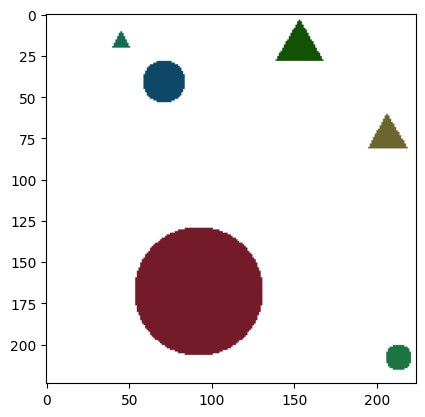

In [6]:
demo_img = plt.imread('train/' + os.listdir('train')[0])
plt.imshow(demo_img)
plt.show()

Tọa độ của bounding box đang lưu trong file json là $(x_1, y_1)$ và $(x_2, y_2)$ (top-left và bottom right), với (0, 0) là vị trí top-left của ảnh. Ta cần chuyển nó về dạng $(x_{center}, y_{center}, w, h)$

Ta sẽ load dữ liệu vào 2 tensor $X$ và $y$, trong đó:
- $X[i]$ là đường dẫn của ảnh thứ $i$
- $y[i]$ có shape là (7, 7, 8), trong đó chiều cuối cùng lưu $(1, x_{center}, y_{center}, w, h, classes)$

**Lưu ý:**
- Hiện tại, các tọa độ của ta đang trong miền giá trị [0, 224]. Trong các bước sau, để mô hình có thể hoạt động tốt, ta sẽ **chuẩn hóa** chúng về miền [0,1] (bằng cách chia cho 224).
- Cũng trong các thao tác sau, tọa độ của tâm $(x_{center}, y_{center})$ sẽ được chuẩn hóa về giá trị có ý nghĩa là ***độ dời*** của tâm so với ***ô lưới chứa nó***

In [13]:
def load_data():
  labels = json.load(open('train/labels.json'))
  n_img = len(labels)

  # Tensor X và y
  X = []
  y = np.zeros((n_img, CELL_SIZE, CELL_SIZE, 5 + n_class))

  for idx, label in enumerate(labels):
    # img = cv2.imread(f'train/{idx}.png')
    # X[idx] = img
    X.append(f'train/{idx}.png')
    for box in label['boxes']:
      # Vector one-hot cho class của obj trong box
      one_hot = [0] * n_class
      one_hot[classes[box['class']]] = 1
      # Tọa độ tâm và w,h của các boundary box
      x1, y1 = box['x1'], box['y1']
      x2, y2 = box['x2'], box['y2']
      x_center, y_center = (x1 + x2) / 2.0, (y1 + y2) /2.0
      w, h = x2 - x1, y2 - y1
      # Xác định vị trí của box trong lưới 7 x 7 (hàng j, cột i)
      i = int(x_center / IMG_SIZE * CELL_SIZE)
      j = int(y_center / IMG_SIZE * CELL_SIZE)
      # Gán vào tensor y
      y[idx, j, i] = 1, x_center, y_center, w, h, *one_hot
  
  return np.array(X), y

In [14]:
images, labels = load_data()

## Chia tập dữ liệu thành train và validation

Với mục đích minh họa, ta sẽ chỉ sử dụng các tập train và validation

In [15]:
img_train, img_test, lb_train, lb_test = train_test_split(images, labels, test_size=0.2, random_state=666)

In [16]:
# Giải phóng bộ nhớ
images = None
labels = None

## Lớp MyGenerator

Ta cần đến lớp này để dùng cho việc huấn luyện mô hình (fetch data theo từng batch)

In [10]:
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img

***Lưu ý:*** Vì số lượng ảnh nhiều và RAM có hạn nên ta sẽ đọc ảnh trong mỗi lần fetch

In [17]:
class MyGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size: (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size: (idx+1) * self.batch_size]

        train_image = []
        train_label = []

        for i in range(0, len(batch_x)):
            img_path = batch_x[i]
            label = batch_y[i].astype(np.float32)
            image = read_img(img_path)
            train_image.append(image)
            train_label.append(label)
        return np.array(train_image), np.array(train_label)


In [18]:
batch_size = 32

train_gen = MyGenerator(img_train, lb_train, batch_size)
val_gen = MyGenerator(img_test, lb_test, batch_size)


Thử kiểm tra xem MyGenerator có hoạt động đúng không:

In [19]:
x_train, y_train = train_gen.__getitem__(0)
x_val, y_val = val_gen.__getitem__(0)
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(32, 224, 224, 3)
(32, 7, 7, 8)
(32, 224, 224, 3)
(32, 7, 7, 8)


## Định nghĩa mô hình CNN

Kiến trúc của mô hình CNN trong Yolov1 tương tự như mạng VGG16, lưu ý rằng toàn bộ activation function đều là hàm tuyến tính. Với tập dữ liệu ta đang dùng, output của mô hình này cần có shape là 7 x 7 x 13.

Ngoài ra, thay vì dùng tầng Dense ở các tầng cuối cùng của mô hình như VGG16, ta thay thế bằng tầng Conv2D với kernel size là 1 x 1.

Kiến trúc của mô hình cơ bản như sau:

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

class ModelCNN(tf.keras.Model):
  def __init__(self, img_size):
    super(ModelCNN, self).__init__()
    self.shape = (img_size, img_size, 3)

    self.conv1 = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=self.shape)
    self.conv2 = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')
    self.maxpool1 = MaxPooling2D(pool_size=2)

    self.conv3 = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.conv4 = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.maxpool2 = MaxPooling2D(pool_size=2)

    self.conv5 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.conv6 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.maxpool3 = MaxPooling2D(pool_size=2)

    self.conv7 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
    self.conv8 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
    self.maxpool4 = MaxPooling2D(pool_size=2)

    self.conv9 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
    self.conv10 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
    self.maxpool5 = MaxPooling2D(pool_size=2)

    self.conv11 = Conv2D(filters=512, kernel_size=1, padding='same', activation='relu')

    self.conv12 = Conv2D(filters=13, kernel_size=1, padding='same', activation='relu')

  def call(self, input):
    x = self.conv1(input)
    x = self.conv2(x)
    x = self.maxpool1(x)

    x = self.conv3(x)
    x = self.conv4(x)
    x = self.maxpool2(x) 

    x = self.conv5(x)
    x = self.conv6(x)
    x = self.maxpool3(x) 

    x = self.conv7(x)
    x = self.conv8(x)
    x = self.maxpool4(x) 

    x = self.conv9(x)
    x = self.conv10(x)
    x = self.maxpool5(x) 

    x = self.conv11(x)

    x = self.conv12(x) 

    return x

## Hàm tính IOU

Khi tính IOU, sử dụng các điểm top-left và bottom-right sẽ dễ dàng hơn so với tọa độ tâm cùng width, height. Do đó, từ dữ liệu thì ta sẽ suy ngược ra lại 2 điểm đó.

In [22]:
def compute_iou(boxes1, boxes2):
    """
    Args:
      boxes1: [BATCH_SIZE, 7, 7, 2, 4]
      boxes2: [BATCH_SIZE, 7, 7, 2, 4]
      , where 4 ===> (x_center, y_center, w, h)
    Return:
      iou: [BATCH_SIZE, CELL_SIZE, CELL_SIZE, BOX_PER_CELL]
    """
    # Chuyển (x_center, y_center, w, h) thành (x1, y1, x2, y2)
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                          boxes1[..., 1] - boxes1[..., 3] / 2.0,
                          boxes1[..., 0] + boxes1[..., 2] / 2.0,
                          boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                          boxes2[..., 1] - boxes2[..., 3] / 2.0,
                          boxes2[..., 0] + boxes2[..., 2] / 2.0,
                          boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)

    # Tính tọa độ top-left và bottom-right
    top_left = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    bottom_right = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    # intersection
    intersection = tf.maximum(0.0, bottom_right - top_left)
    inter_square = intersection[..., 0] * intersection[..., 1]

    # Diện tích của boxes1 và boxes2
    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    # union
    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)

    # Thực hiện "clip" (giá trị nhỏ hơn 0 sẽ thành 0, lớn hơn 1 sẽ thành 1)
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)    

## Hàm lỗi

Ta quan tâm đến 3 giá trị lỗi sau:
- **Confidence loss:** Giá trị này liên quan đến việc dự đoán 1 boundary box có chứa object hay không. Nó được tính trên cả những ô chứa object và không chứa object của lưới.
$$L_{confidence} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} (C_i - \hat{C_i})^2 + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{noobj} (C_i - \hat{C_i})^2 $$
Trong công thức trên:
  - $S$ là CELL_SIZE (7)
  - $B$ là BOX_PER_CELL (2)
  - $\mathbb{I}_{ij}^{obj}$ chỉ những boundary box thứ $j$ tại ô lưới $i$ mà được dự đoán là có chứa object và nhãn của nó là đúng như vậy. Tương tự với $\mathbb{I}_{ij}^{noobj}$.
  - $C_i$ là giá trị confidence dự đoán, $\hat{C_i}$ chính là giá trị IOU giữa boundary box dự đoán và ground truth
  - Trọng số $\lambda_{noobj}$ dùng để giảm bớt giá trị lỗi tại những ô lưới không chứa object.
    
    Khi cài đặt, ta sẽ sử dụng kĩ thuật masking để tính giá trị loss này.

- **Localization loss:** Ta cần tính lỗi cho các dự đoán về tọa độ tâm và width, height của các boundary box. Tất nhiên rằng giá trị này chỉ tính tại những ô lưới có chứa object. Tại mỗi ô lưới, ta chọn ra boundary box có IOU lớn nhất, rồi tính lỗi đối với boundary box đó.
$$L_{localization} = \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} \left [ (x_i - \hat{x_i})^2 + (y_i - \hat{y_i})^2  + (w_i - \hat{w_i})^2 + (h_i - \hat{h_i})^2 \right ] $$
Lưu ý rằng, tọa độ các tâm của ta đều cần được chuẩn hóa về giá trị ***độ dời *** so với ô lưới chứa nó

- **Classification loss:** Giá trị này sẽ chỉ được tính tại những ô lưới có label là "có chứa object". Trong paper gốc của Yolov1, hàm lỗi được sử dụng cho giá trị này cũng là Sum Square Error
$$L_{classification} = \sum_{i=0}^{S^2} \mathbb{I}_{i}^{obj} \sum_{c \in classes} (p_i(c) - \hat{p_i(c)})^2  $$


Từ đó, hàm lỗi của ta sẽ là
$$ L = L_{confidence} + L_{localization} + L_{classification}$$

In [24]:
# Hai hằng số lambda
N_COORD = 10
N_NOOBJ = 0.1

In [25]:
# Tạo các tensor board_x, board_y để dùng cho việc chuyển đổi giữa độ dời
# tương đối và tọa độ thật của các tâm
# Ví dụ:
# board_x = 0 1 2 3
#           0 1 2 3
#           0 1 2 3
#           0 1 2 3
# board_y = 0 0 0 0
#           1 1 1 1
#           2 2 2 2
#           3 3 3 3
board_x = np.transpose(
    np.reshape(
        np.array([np.arange(CELL_SIZE)] * CELL_SIZE * BOX_PER_CELL),
        (BOX_PER_CELL, CELL_SIZE, CELL_SIZE)
    ),
    (1, 2, 0))    # 7 * 7 * 2
board_x = board_x[None, :]    # 1 * 7 * 7 * 2
board_x = tf.constant(board_x, dtype=tf.float32)
board_y = tf.transpose(board_x, (0, 2, 1, 3))   # 1 * 7 * 7 * 2

In [32]:
def yolo_loss(labels, predicts, evaluate=False):
    """
    Args:
      predicts: [BATCH_SIZE, 7, 7, 13] 
      labels: [BATCH_SIZE, 7, 7, 8]
    Return:
      loss: scalar
    """
    # 2 phần tử đầu của vector dự đoán tại một ô lưới là confidence score
    predict_object = predicts[..., :BOX_PER_CELL]   # _ * 7 * 7 * 2
    
    # 8 phần tử tiếp theo là dự đoán tọa độ tâm (độ dời) của boundary box và width height
    predict_box_offset = tf.reshape(
                                    predicts[...,BOX_PER_CELL:5*BOX_PER_CELL],
                                    (-1, CELL_SIZE, CELL_SIZE, BOX_PER_CELL, 4))
    #   --> _ * 7 * 7 * 2 * 4

    # Các phần tử cuối là dự đoán lớp của object
    predict_class = predicts[...,5*BOX_PER_CELL:]   # _ * 7 * 7 * 3
    
    # Chuyển các giá trị độ dời của tâm về toạ độ normalize trên khoảng [0-1],
    # đồng thời tính luôn giá trị w^2 và h^2
    predict_normalized_box = tf.stack(
        [
          (predict_box_offset[..., 0] + board_x) / CELL_SIZE,
          (predict_box_offset[..., 1] + board_y) / CELL_SIZE,
          tf.square(predict_box_offset[..., 2]),
          tf.square(predict_box_offset[..., 3])
        ],
        axis=-1)    # _ * 7 * 7 * 2 * 4

    if evaluate:
        return predict_object, predict_class, predict_normalized_box

    # Các label tương ứng 
    true_object = labels[..., :1]   # _ * 7 * 7 * 1
    true_box = tf.reshape(labels[..., 1:5], (-1, CELL_SIZE, CELL_SIZE, 1, 4))  # _ * 7 * 7 * 1 * 4 
    
    # Normalize tọa độ pixel về đoạn [0-1] (chia cho IMG_SIZE), đồng thời
    # duplicate lưới 7 x 7
    true_normalized_box = tf.tile(true_box, (1, 1, 1, BOX_PER_CELL, 1)) / IMG_SIZE
    #   ---> _ * 7 * 7 * 2 * 4
    
    true_class = labels[..., 5:]    # _ * 7 * 7 * 3
    
    # Tính giá trị độ dời của tâm từ label
    true_box_offset =  tf.stack(
        [
          true_normalized_box[..., 0] * CELL_SIZE - board_x,
          true_normalized_box[..., 1] * CELL_SIZE - board_y,
          tf.sqrt(true_normalized_box[..., 2]),
          tf.sqrt(true_normalized_box[..., 3])
        ],
        axis=-1)    # _ * 7 * 7 * 2 * 4

    # Tính IOU
    predict_iou = compute_iou(true_normalized_box, predict_normalized_box)   # _ * 7 * 7 * 2
    
    # Tại mỗi ô lưới, tìm giá trị IOU lớn nhất của 2 bounding box trong ô đó
    predict_iou_max = tf.reduce_max(predict_iou, 3, keepdims=True)  # _ * 7 * 7 * 1

    # Tính IOU metric để monitor trong lúc train
    # iou_metric = tf.reduce_mean(
    #                             tf.reduce_sum(predict_iou_max, axis=[1,2,3])
    #                             /
    #                             tf.reduce_sum(true_object, axis=[1,2,3])
    #                            )

    # obj_mask có shape _ * 7 * 7 * 2, tensor 7 * 7 sẽ bằng 1 tại các ô lưới có
    # boundary box được dự đoán là có chứa object và nhãn của ô lưới đó cũng là có chứa object
    obj_mask = tf.cast((predict_iou >= predict_iou_max), tf.float32) * true_object

    # Ngược lại với obj_mask:
    noobj_mask = tf.ones_like(obj_mask) - obj_mask

    # Confidence loss:
    # + Phần có chứa obj
    # obj_delta = obj_mask * (1 - predict_object)
    obj_delta = obj_mask * (predict_object - predict_iou)
    obj_loss = tf.reduce_mean(tf.reduce_sum(tf.square(obj_delta), axis=[1,2,3]), name='object_loss')
    # + Phần không chứa obj
    noobj_delta = noobj_mask * predict_object
    noobj_loss = tf.reduce_mean(tf.reduce_sum(tf.square(noobj_delta), axis=[1,2,3]), name='noobject_loss')
    # Tổng:
    conf_loss = obj_loss + N_NOOBJ * noobj_loss

    # Classification loss: chỉ tính tại những ô lưới có label là "chứa object"
    class_delta = true_object * (predict_class - true_class)
    class_loss = tf.reduce_mean(
                                tf.reduce_sum(tf.square(class_delta), axis=[1,2,3]),
                                name='class_loss')

    ## Localization loss
    box_mask = tf.expand_dims(obj_mask, 4)    # _ * 7 * 7 * 2 * 1
    box_delta = box_mask * (predict_box_offset - true_box_offset)   # _ * 7 * 7 * 2 * 4
    local_loss = tf.reduce_mean(tf.reduce_sum(tf.square(box_delta), axis=[1,2,3]), name='local_loss')
    local_loss *= N_COORD

    # Giá trị loss của mô hình:
    loss = conf_loss + class_loss + local_loss
    
    # return loss, iou_metric, predict_object, predict_class, predict_normalized_box
    return loss

## Huấn luyện

Trong quá trình huấn luyện, metrics của mô hình sẽ là IOU

Tạo mô hình từ lớp ModelCNN:

In [30]:
model = ModelCNN(IMG_SIZE)

Biên dịch và train bằng các hàm có sẵn:

In [33]:
model.compile(loss=yolo_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [34]:
model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20
625/625 [==============================] - 57s 85ms/step - loss: 6.0985 - val_loss: 0.2925
Epoch 2/20
625/625 [==============================] - 53s 86ms/step - loss: 0.2141 - val_loss: 0.1628
Epoch 3/20
625/625 [==============================] - 61s 97ms/step - loss: 0.1375 - val_loss: 0.1521
Epoch 4/20
625/625 [==============================] - 57s 92ms/step - loss: 0.1156 - val_loss: 0.1247
Epoch 5/20
625/625 [==============================] - 61s 97ms/step - loss: 0.0938 - val_loss: 0.1188
Epoch 6/20
625/625 [==============================] - 71s 114ms/step - loss: 0.0878 - val_loss: 0.1105
Epoch 7/20
625/625 [==============================] - 83s 133ms/step - loss: 0.0780 - val_loss: 0.1003
Epoch 8/20
625/625 [==============================] - 91s 145ms/step - loss: 0.0807 - val_loss: 0.1760
Epoch 9/20
625/625 [==============================] - 102s 164ms/step - loss: 0.1044 - val_loss: 0.1006
Epoch 10/20
625/625 [==============================] - 121s 193ms/step - loss

### Tự code hàm train (toang)

Thiết lập thuật toán tối ưu:

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_loss = tf.keras.metrics.Mean()
train_metric = tf.keras.metrics.Mean()
test_loss = tf.keras.metrics.Mean()
test_metric = tf.keras.metrics.Mean()

Cài đặt hàm train và test với tf.GradientTape:

In [23]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    # loss, metric, *_ = yolo_loss(predictions, labels)
    loss = yolo_loss(predictions, labels)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss.update_state(loss)
#   train_metric.update_state(metric)

@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
#   t_loss, t_metric, *_ = yolo_loss(predictions, labels)
  t_loss = yolo_loss(predictions, labels)
  test_loss.update_state(t_loss)
#   test_metric.update_state(t_metric)

Huấn luyện:

In [24]:
EPOCHS = 10
BATCH_SIZE = 64

for epoch in range(EPOCHS):
  start_time = time.time()

  train_loss.reset_states()
#   train_metric.reset_states()
  test_loss.reset_states()
#   test_metric.reset_states()

  for batch in range(len(X_train) // BATCH_SIZE):
    X_batch = X_train[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE].astype('float32')
    y_batch = y_train[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE].astype('float32')
    train_step(X_batch, y_batch)

  for batch in range(len(X_val) // BATCH_SIZE):
    X_batch = X_val[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE].astype('float32')
    y_batch = y_val[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE].astype('float32')
    test_step(X_batch, y_batch)
    
  print(
    f'Epoch {epoch + 1}, '
    f'Train Loss: {train_loss.result()}, '
    # f'Train IOU: {train_metric.result()}, '
    f'Val Loss: {test_loss.result()}, '
    # f'Val IOU: {test_metric.result()}'
  )

  print("Time taken: %.2fs" % (time.time() - start_time))

Epoch 1, Train Loss: 258420.359375, Val Loss: 1217.0992431640625, 
Time taken: 46.58s


KeyboardInterrupt: 

## Dự đoán

Hàm tính IOU giữa 2 box:

In [35]:
def compute_iou_2_boxes(box1, box2):
    """
    Args:
      box1: [center_x, center_y, w, h] 
      box2: [center_x, center_y, w, h] 
    Return:
      iou: iou
    """
    x1 = max(box1[0] - 0.5 * box1[2], box2[0] - 0.5 * box2[2])
    y1 = max(box1[1] - 0.5 * box1[3], box2[1] - 0.5 * box2[3])
    x2 = min(box1[0] + 0.5 * box1[2], box2[0] + 0.5 * box2[2])
    y2 = min(box1[1] + 0.5 * box1[3], box2[1] + 0.5 * box2[3])
    w = x2 - x1
    h = y2 - y1
    intersect = 0 if w < 0 or w < 0 else w * h
    union = box1[2] * box1[3] + box2[2] * box2[3] - intersect
    return intersect / union


Từ ảnh đầu vào, ta cần có những giá trị `predict_object`, `predict_class`, `predict_normalized_box`

In [36]:
def predict(img):
  img_batch = np.expand_dims(img, 0)
  predicts = model(img_batch, training=False)
  
  # 2 phần tử đầu của vector dự đoán tại một ô lưới là confidence score
  predict_object = predicts[..., :BOX_PER_CELL]   # _ * 7 * 7 * 2
  
  # 8 phần tử tiếp theo là dự đoán tọa độ tâm (độ dời) của boundary box và width height
  predict_box_offset = tf.reshape(
                                  predicts[..., BOX_PER_CELL:5*BOX_PER_CELL],
                                  (-1, CELL_SIZE, CELL_SIZE, BOX_PER_CELL, 4))
  #   --> _ * 7 * 7 * 2 * 4

  # Các phần tử cuối là dự đoán lớp của object
  predict_class = predicts[..., 5*BOX_PER_CELL:]   # _ * 7 * 7 * 3
  
  # Chuyển các giá trị độ dời của tâm về toạ độ normalize trên khoảng [0-1],
  # đồng thời tính giá trị w và h (vì trong lúc dự đoán thì ta đoán căn bậc 2 của chúng)
  predict_normalized_box = tf.stack(
      [
        (predict_box_offset[..., 0] + board_x) / CELL_SIZE,
        (predict_box_offset[..., 1] + board_y) / CELL_SIZE,
        tf.square(predict_box_offset[..., 2]),
        tf.square(predict_box_offset[..., 3])
      ],
      axis=-1)    # _ * 7 * 7 * 2 * 4

  return predict_object.numpy(), predict_class.numpy(), predict_normalized_box.numpy()

Để chuẩn bị cho việc suy ra kết quả, ta cần chú ý những điều sau:
- Xác suất để một boundary box chứa 1 class nào đó:
$$ P(class) = P(obj)  P(class|obj) $$
- Ta sẽ giữ lại những boundary box có xác suất chứa 1 class nào đó lớn hơn 1 ngưỡng nhất định (giả sử là 0.2)
- Tại các boundary box, tìm ra class có xác suất cao nhất
- Trong 2 boundary box của 1 ô lưới, tìm ra boundary box có xác suất dự đoán class trên cao hơn để giữ lại và bỏ đi boundary box kia

In [37]:
def interpret_output(predict_object, predict_class, predict_normalized_box):
    # Nhân với IMG_SIZE để ra giá trị gốc (vì đây là đã chuẩn hóa về [0,1])
    predict_box = predict_normalized_box * IMG_SIZE   # 7 * 7 * 2 * 4
    predict_object = np.expand_dims(predict_object, axis=-1)  # 7 * 7 * 2 * 1
    predict_class = np.expand_dims(predict_class, axis=-2)  # 7 * 7 * 1 * 3
    
    # Xác suất mỗi boundary box chứa class
    class_probs = predict_object * predict_class  # 7 * 7 * 2 * 3
    
    # Giữ các boundary box mà có xác suất chứa 1 class nào đó >= 0.3
    filter_mat_probs = np.array(class_probs >= 0.3, dtype='bool') # 7 * 7 * 2 * 3
    filter_mat_boxes = np.nonzero(filter_mat_probs)
    class_probs_filtered = class_probs[filter_mat_probs]
    boxes_filtered = predict_box[filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]
    
    # Chọn index của lớp có xác xuất lớn nhất tại mỗi boundary box
    classes_num_filtered = np.argmax(class_probs, axis=3)[filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]
    
    # Sắp xếp theo thứ tự giảm dần xác suất dự đoán class
    argsort = np.array(np.argsort(class_probs_filtered))[::-1]
    boxes_filtered = boxes_filtered[argsort]
    class_probs_filtered = class_probs_filtered[argsort]
    classes_num_filtered = classes_num_filtered[argsort]

    # Giữ lại boundary box có xác xuất dự đoán lớn nhất
    # --> Thuật toán non-maximun suppression
    for i in range(len(boxes_filtered)):
        if class_probs_filtered[i] == 0:
            continue
        # Tìm những box có xác suất nhỏ hơn box thứ i
        for j in range(i + 1, len(boxes_filtered)):
            # Nếu IOU giữa box i và box j > 0.4 thì loại box j
            if compute_iou_2_boxes(boxes_filtered[i], boxes_filtered[j]) > 0.4:
                class_probs_filtered[j] = 0.0   # Đánh dấu là loại box j
                
    # Bỏ những boundary vừa bị loại bởi thuật toán trên ra khỏi array
    filter_iou = np.array(class_probs_filtered > 0.0, dtype='bool')
    boxes_filtered = boxes_filtered[filter_iou]
    class_probs_filtered = class_probs_filtered[filter_iou]
    classes_num_filtered = classes_num_filtered[filter_iou]
    
    result = []
    for i in range(len(boxes_filtered)):
        result.append(
            [classes_num_filtered[i],
             boxes_filtered[i][0],
             boxes_filtered[i][1],
             boxes_filtered[i][2],
             boxes_filtered[i][3],
             class_probs_filtered[i]])

    return result


In [38]:
def draw_result(img, result):
    """
    Args:
      img: ảnh      
      result: giá trị sinh ra ở hàm trên    
    """
    plt.figure(figsize=(10,10), dpi=40)
    img = np.pad(img, [(50,50), (50,50), (0,0)], mode='constant', constant_values=255)
    for i in range(len(result)):
        x = int(result[i][1]) + 50
        y = int(result[i][2]) + 50
        w = int(result[i][3] / 2)
        h = int(result[i][4] / 2)

        cv2.rectangle(img, (x - w, y - h), (x + w, y + h), (255, 0, 0), 2)
        cv2.rectangle(img, (x - w, y - h - 20),
                      (x -w + 50, y - h), (0, 255, 0), -1)
        cv2.putText(
            img, '{} : {:.2f}'.format(result[i][0] ,result[i][5]),
            (x - w + 5, y - h - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.3,
            (0, 0, 0), 1, cv2.LINE_AA)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [39]:
def final_predict(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    predict_object, predict_class, predict_normalized_box = predict(img.astype('float32'))
    result = interpret_output(predict_object[0], predict_class[0], predict_normalized_box[0])
    draw_result(img, result)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


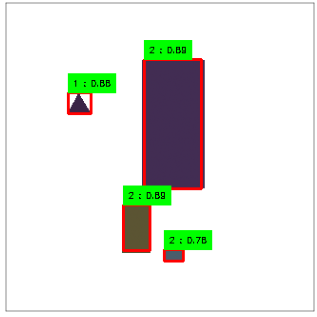

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


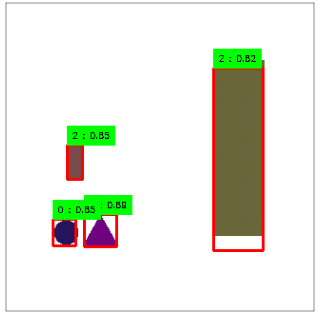

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


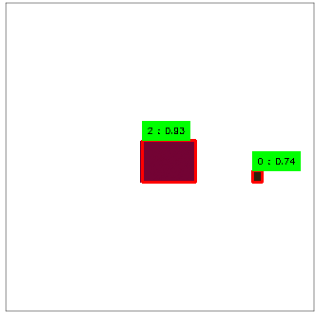

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


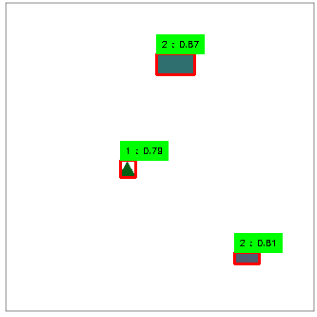

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


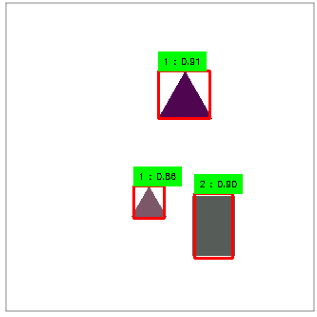

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


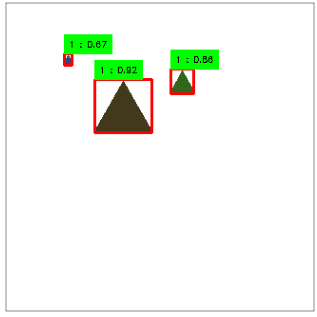

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


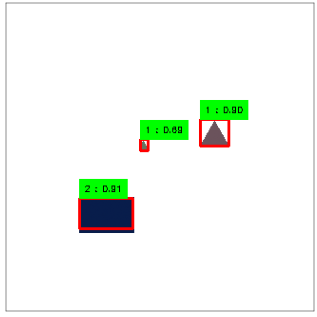

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


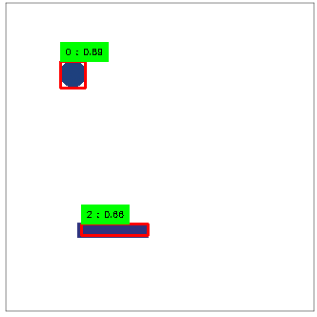

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


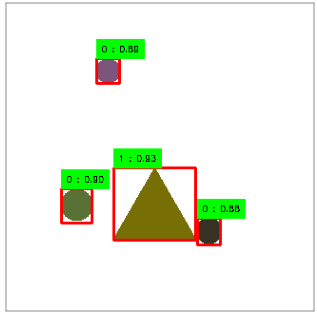

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


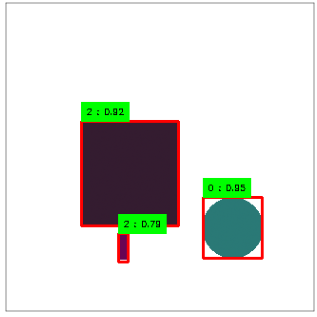

In [40]:
for i in range(10):
    img = img_test[i]
    final_predict(img)